<a href="https://colab.research.google.com/github/Ehat825/Ehat825.github.io/blob/main/Image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision import models
import torchvision.transforms as T
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F

transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])
target_transform = T.Compose([
    T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
    T.PILToTensor()
])

train_dataset = VOCSegmentation(root='path/to/data', year='2012', image_set='train', download=True,
                                 transform=transform, target_transform=target_transform)
test_dataset = VOCSegmentation(root='path/to/data', year='2012', image_set='val', download=True,
                                transform=transform, target_transform=target_transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


100%|██████████| 2.00G/2.00G [01:14<00:00, 26.8MB/s]


This cell just defines the models, I had initially wanted to have skip connections be toggleable but I ran into issues.

In [ ]:
class ResNetSegmentation(nn.Module):
    def __init__(self, num_classes=21):
        super(ResNetSegmentation, self).__init__()
        resnet = models.resnet50(pretrained=True)

        # Encoder layers
        self.conv1 = resnet.conv1      # 64 channels, output size: input/2
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool  # output size: input/4

        self.layer1 = resnet.layer1    # 256 channels, output size: input/4
        self.layer2 = resnet.layer2    # 512 channels, output size: input/8
        self.layer3 = resnet.layer3    # 1024 channels, output size: input/16
        self.layer4 = resnet.layer4    # 2048 channels, output size: input/32

        # Decoder layers with skip connections
        self.up1 = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )  # output: 512 channels, size: input/16

        self.up2 = nn.Sequential(
            nn.Conv2d(512 + 1024, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )  # output: 256 channels, size: input/8

        self.up3 = nn.Sequential(
            nn.Conv2d(256 + 512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )  # output: 128 channels, size: input/4

        self.up4 = nn.Sequential(
            nn.Conv2d(128 + 256, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )  # output: 64 channels, size: input/2

        self.up5 = nn.Sequential(
            nn.Conv2d(64 + 64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )  # output: 32 channels, size: input size

        # Final classification layer
        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        # Store input size for potential final adjustment
        input_size = x.size()[2:]

        # Encoder path with feature extraction at each level
        x1 = self.relu(self.bn1(self.conv1(x)))       # size: input/2
        x2 = self.maxpool(x1)                         # size: input/4
        x2 = self.layer1(x2)                          # size: input/4
        x3 = self.layer2(x2)                          # size: input/8
        x4 = self.layer3(x3)                          # size: input/16
        x5 = self.layer4(x4)                          # size: input/32

        # Decoder path with skip connections
        p5 = self.up1(x5)                             # size: input/16
        p4 = self.up2(torch.cat([p5, x4], dim=1))     # size: input/8
        p3 = self.up3(torch.cat([p4, x3], dim=1))     # size: input/4
        p2 = self.up4(torch.cat([p3, x2], dim=1))     # size: input/2
        p1 = self.up5(torch.cat([p2, x1], dim=1))     # size: same as input


        # Ensure output logits are reasonable
        logits = self.classifier(p1)

        # Optional: Apply log_softmax instead of raw logits
        logits = F.log_softmax(logits, dim=1)


        # Add this extra check to ensure output size exactly matches input size
        if logits.size()[2:] != input_size:
            logits = nn.functional.interpolate(logits, size=input_size,
                                             mode='bilinear', align_corners=True)

        return logits


class ResNetSegmentationDeconv(nn.Module):
    def __init__(self, num_classes=21):
        super(ResNetSegmentationDeconv, self).__init__()
        resnet = models.resnet50(pretrained=True)

        # Encoder layers
        self.conv1 = resnet.conv1      # 64 channels, output size: input/2
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool  # output size: input/4

        self.layer1 = resnet.layer1    # 256 channels, output size: input/4
        self.layer2 = resnet.layer2    # 512 channels, output size: input/8
        self.layer3 = resnet.layer3    # 1024 channels, output size: input/16
        self.layer4 = resnet.layer4    # 2048 channels, output size: input/32

        # Decoder layers with skip connections using transposed convolutions
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(2048, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )  # output: 512 channels, size: input/16

        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(512 + 1024, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )  # output: 256 channels, size: input/8

        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(256 + 512, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )  # output: 128 channels, size: input/4

        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(128 + 256, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )  # output: 64 channels, size: input/2

        self.up5 = nn.Sequential(
            nn.ConvTranspose2d(64 + 64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )  # output: 32 channels, size: input size

        # Final classification layer
        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        # Store input size for potential final adjustment
        input_size = x.size()[2:]

        # Encoder path with feature extraction at each level
        x1 = self.relu(self.bn1(self.conv1(x)))       # size: input/2
        x2 = self.maxpool(x1)                         # size: input/4
        x2 = self.layer1(x2)                          # size: input/4
        x3 = self.layer2(x2)                          # size: input/8
        x4 = self.layer3(x3)                          # size: input/16
        x5 = self.layer4(x4)                          # size: input/32

        # Decoder path with skip connections
        p5 = self.up1(x5)                             # size: input/16
        p4 = self.up2(torch.cat([p5, x4], dim=1))     # size: input/8
        p3 = self.up3(torch.cat([p4, x3], dim=1))     # size: input/4
        p2 = self.up4(torch.cat([p3, x2], dim=1))     # size: input/2
        p1 = self.up5(torch.cat([p2, x1], dim=1))     # size: same as input

        # Ensure output logits are reasonable
        logits = self.classifier(p1)

        # Optional: Apply log_softmax instead of raw logits
        logits = F.log_softmax(logits, dim=1)

        # Add this extra check to ensure output size exactly matches input size
        if logits.size()[2:] != input_size:
            logits = nn.functional.interpolate(logits, size=input_size,
                                             mode='bilinear', align_corners=True)

        return logits




This is the actual training loop, it takes a while.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize both models
model_standard = ResNetSegmentation(num_classes=21).to(device)
model_deconv = ResNetSegmentationDeconv(num_classes=21).to(device)

# Create separate optimizers for each model
optimizer_standard = torch.optim.Adam(model_standard.parameters(), lr=1e-4)
optimizer_deconv = torch.optim.Adam(model_deconv.parameters(), lr=1e-4)

criterion = nn.CrossEntropyLoss(ignore_index=255)
num_epochs = 20

# Initialize separate loss arrays for each model
train_losses_standard = []
val_losses_standard = []
train_losses_deconv = []
val_losses_deconv = []

for epoch in range(num_epochs):
    # ---------- Training Standard Model ----------
    model_standard.train()
    total_train_loss_standard = 0

    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.squeeze(1).long().to(device)

        outputs = model_standard(imgs)
        loss = criterion(outputs, masks)

        optimizer_standard.zero_grad()
        loss.backward()
        optimizer_standard.step()

        total_train_loss_standard += loss.item()

    avg_train_loss_standard = total_train_loss_standard / len(train_loader)
    train_losses_standard.append(avg_train_loss_standard)

    # ---------- Validation Standard Model ----------
    model_standard.eval()
    total_val_loss_standard = 0

    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs = imgs.to(device)
            masks = masks.squeeze(1).long().to(device)

            outputs = model_standard(imgs)
            loss = criterion(outputs, masks)

            total_val_loss_standard += loss.item()

    avg_val_loss_standard = total_val_loss_standard / len(test_loader)
    val_losses_standard.append(avg_val_loss_standard)

    # ---------- Training Deconv Model ----------
    model_deconv.train()
    total_train_loss_deconv = 0

    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.squeeze(1).long().to(device)

        outputs = model_deconv(imgs)
        loss = criterion(outputs, masks)

        optimizer_deconv.zero_grad()
        loss.backward()
        optimizer_deconv.step()

        total_train_loss_deconv += loss.item()

    avg_train_loss_deconv = total_train_loss_deconv / len(train_loader)
    train_losses_deconv.append(avg_train_loss_deconv)

    # ---------- Validation Deconv Model ----------
    model_deconv.eval()
    total_val_loss_deconv = 0

    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs = imgs.to(device)
            masks = masks.squeeze(1).long().to(device)

            outputs = model_deconv(imgs)
            loss = criterion(outputs, masks)

            total_val_loss_deconv += loss.item()

    avg_val_loss_deconv = total_val_loss_deconv / len(test_loader)
    val_losses_deconv.append(avg_val_loss_deconv)

    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Standard Model - Train Loss: {avg_train_loss_standard:.4f} - Val Loss: {avg_val_loss_standard:.4f}")
    print(f"Deconv Model - Train Loss: {avg_train_loss_deconv:.4f} - Val Loss: {avg_val_loss_deconv:.4f}")
    print("-" * 60)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s]


Epoch 1/20
Standard Model - Train Loss: 2.1495 - Val Loss: 1.8510
Deconv Model - Train Loss: 2.5651 - Val Loss: 2.2099
------------------------------------------------------------
Epoch 2/20
Standard Model - Train Loss: 1.7046 - Val Loss: 1.4917
Deconv Model - Train Loss: 2.0976 - Val Loss: 1.9186
------------------------------------------------------------
Epoch 3/20
Standard Model - Train Loss: 1.4116 - Val Loss: 1.2090
Deconv Model - Train Loss: 1.7397 - Val Loss: 1.6037
------------------------------------------------------------
Epoch 4/20
Standard Model - Train Loss: 1.1652 - Val Loss: 1.0583
Deconv Model - Train Loss: 1.4312 - Val Loss: 1.3980
------------------------------------------------------------
Epoch 5/20
Standard Model - Train Loss: 0.9468 - Val Loss: 0.9966
Deconv Model - Train Loss: 1.1795 - Val Loss: 1.2221
------------------------------------------------------------
Epoch 6/20
Standard Model - Train Loss: 0.7836 - Val Loss: 0.7829
Deconv Model - Train Loss: 0.9888 

This shows our loss curves

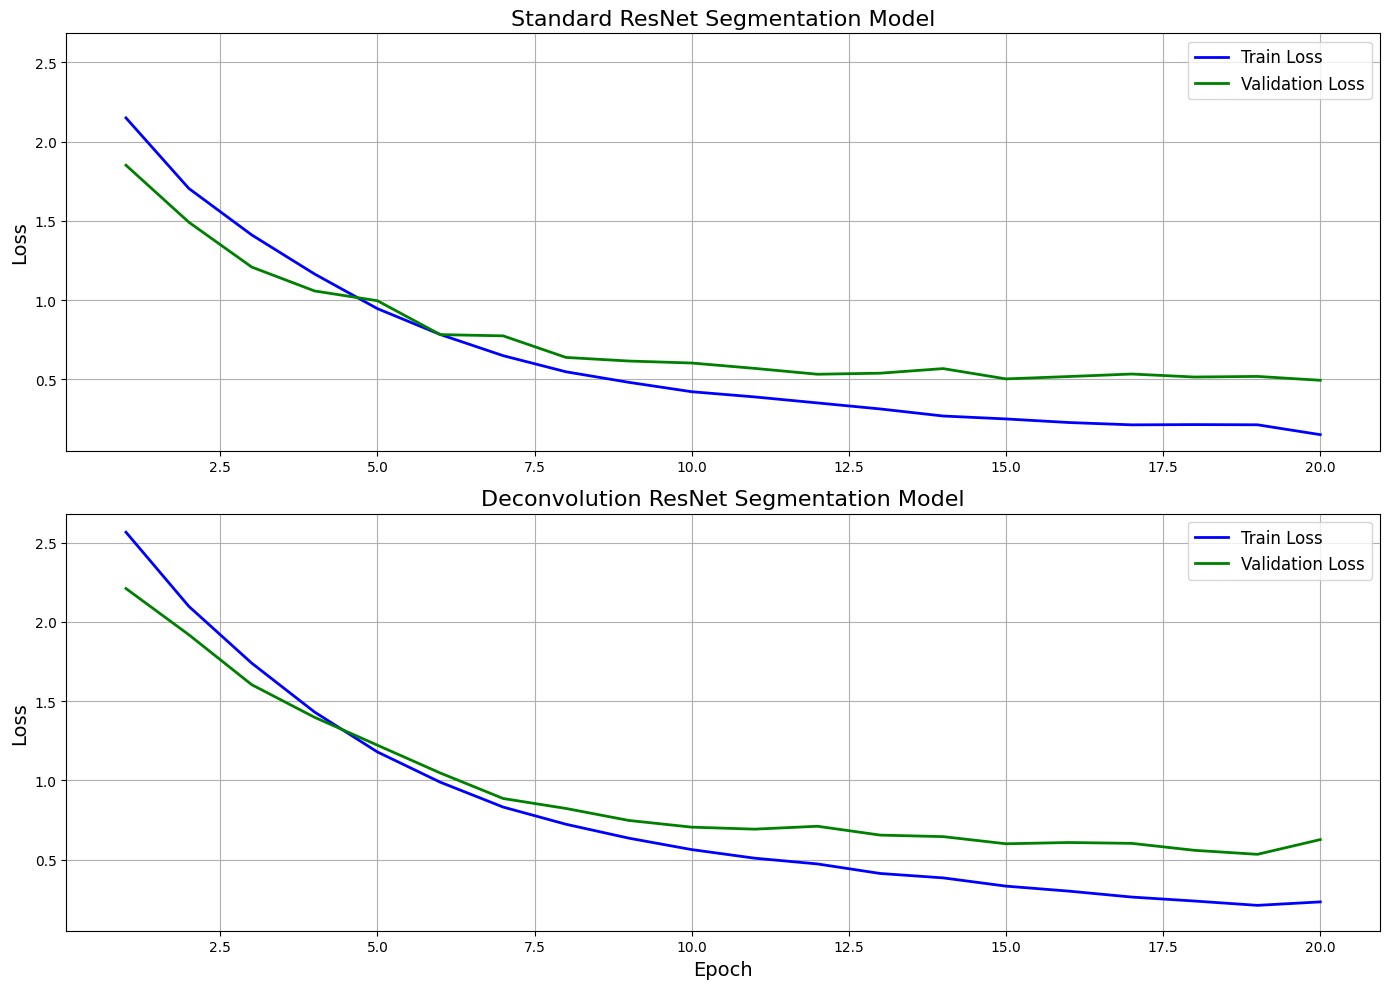

In [ ]:
import matplotlib.pyplot as plt

# Optional: Plot in separate subplots for clearer comparison
plt.figure(figsize=(14, 10))

# Define consistent colors
train_color = 'blue'
val_color = 'green'
epochs = range(1, num_epochs + 1)
# Standard model subplot
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses_standard, color=train_color, linewidth=2, label='Train Loss')
plt.plot(epochs, val_losses_standard, color=val_color, linewidth=2, label='Validation Loss')
plt.title('Standard ResNet Segmentation Model', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)

# Deconv model subplot
plt.subplot(2, 1, 2)
plt.plot(epochs, train_losses_deconv, color=train_color, linewidth=2, label='Train Loss')
plt.plot(epochs, val_losses_deconv, color=val_color, linewidth=2, label='Validation Loss')
plt.title('Deconvolution ResNet Segmentation Model', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)

# Get y-axis limits from both subplots
ax1 = plt.subplot(2, 1, 1)  # Get the first subplot axes
ax2 = plt.subplot(2, 1, 2)  # Get the second subplot axes

# Find the minimum and maximum y-values across both subplots
ymin = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
ymax = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

# Set the y-axis limits to be the same for both subplots
ax1.set_ylim([ymin, ymax])
ax2.set_ylim([ymin, ymax])
plt.tight_layout()
plt.show()

In [ ]:
from collections import defaultdict
def get_predictions(model_standard, model_deconv, test_loader, device):
    """
    Generates predictions for both models without saving/loading logic.

    Args:
        model_standard: The standard ResNet segmentation model
        model_deconv: The deconvolution ResNet segmentation model
        test_loader: DataLoader for validation dataset
        device: Device to run inference on (cuda or cpu)

    Returns:
        predictions_standard: List of prediction tensors from standard model
        predictions_deconv: List of prediction tensors from deconv model
        ground_truth: List of ground truth masks
        images: List of original input images
    """
    predictions_standard = []
    predictions_deconv = []
    ground_truth = []
    images = []

    # Set models to evaluation mode
    model_standard.eval()
    model_deconv.eval()

    with torch.no_grad():
        for imgs, masks in tqdm(test_loader, desc="Processing validation data"):
            imgs = imgs.to(device)
            masks = masks.squeeze(1).long().to(device)

            # Get predictions from both models
            outputs_standard = model_standard(imgs)
            outputs_deconv = model_deconv(imgs)

            # Get the predicted class
            _, preds_standard = torch.max(outputs_standard, dim=1)
            _, preds_deconv = torch.max(outputs_deconv, dim=1)

            # Move tensors to CPU for storage
            predictions_standard.append(preds_standard.cpu())
            predictions_deconv.append(preds_deconv.cpu())
            ground_truth.append(masks.cpu())
            images.append(imgs.cpu())

    return predictions_standard, predictions_deconv, ground_truth, images


# Function to visualize a batch of predictions
def visualize_predictions(predictions_standard, predictions_deconv, ground_truth, images,
                         batch_idx=0, sample_idx=0, class_colors=None):
    """
    Visualizes predictions from both models for a specific image

    Args:
        predictions_standard: List of prediction tensors from standard model
        predictions_deconv: List of prediction tensors from deconv model
        ground_truth: List of ground truth masks
        images: List of original input images
        batch_idx: Batch index to visualize
        sample_idx: Sample index within the batch
        class_colors: Dictionary mapping class indices to RGB colors
    """
    if class_colors is None:
        # Default color map (can be replaced with actual class colors)
        cmap = plt.cm.get_cmap('tab20', 21)
        class_colors = {i: cmap(i)[:3] for i in range(21)}

    # Get the specific predictions
    pred_std = predictions_standard[batch_idx][sample_idx].numpy()
    pred_deconv = predictions_deconv[batch_idx][sample_idx].numpy()
    gt = ground_truth[batch_idx][sample_idx].numpy()
    img = images[batch_idx][sample_idx].permute(1, 2, 0).numpy()

    # Normalize image for visualization
    img = (img - img.min()) / (img.max() - img.min())

    # Create color-coded segmentation masks
    def create_color_mask(prediction):
        h, w = prediction.shape
        color_mask = np.zeros((h, w, 3))
        for class_idx, color in class_colors.items():
            mask = prediction == class_idx
            color_mask[mask] = color
        return color_mask

    std_color = create_color_mask(pred_std)
    deconv_color = create_color_mask(pred_deconv)
    gt_color = create_color_mask(gt)

    # Create visualization
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(gt_color)
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(std_color)
    plt.title('Standard Model')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(deconv_color)
    plt.title('Deconv Model')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Example usage:
# After training the models, you can do:
"""
# Save or load predictions
predictions_standard, predictions_deconv, ground_truth, images = save_or_load_predictions(
    model_standard, model_deconv, test_loader, device)

# Visualize some predictions
visualize_predictions(predictions_standard, predictions_deconv, ground_truth, images,
                     batch_idx=0, sample_idx=3)
"""

# Compute metrics based on predictions
def compute_metrics(predictions_standard, predictions_deconv, ground_truth, num_classes=21):
    """
    Compute evaluation metrics (IoU, pixel accuracy) for both models

    Args:
        predictions_standard: List of prediction tensors from standard model
        predictions_deconv: List of prediction tensors from deconv model
        ground_truth: List of ground truth masks
        num_classes: Number of segmentation classes

    Returns:
        metrics: Dictionary containing evaluation metrics for both models
    """
    # Initialize confusion matrices
    conf_matrix_standard = np.zeros((num_classes, num_classes))
    conf_matrix_deconv = np.zeros((num_classes, num_classes))

    # Flatten and concatenate all batches
    all_preds_std = torch.cat([p.flatten() for p in predictions_standard])
    all_preds_deconv = torch.cat([p.flatten() for p in predictions_deconv])
    all_gt = torch.cat([g.flatten() for g in ground_truth])

    # Convert to numpy for processing
    all_preds_std = all_preds_std.numpy()
    all_preds_deconv = all_preds_deconv.numpy()
    all_gt = all_gt.numpy()

    # Create mask for valid pixels (ignore index 255 if used)
    valid_mask = all_gt != 255

    # Filter out invalid pixels
    all_preds_std = all_preds_std[valid_mask]
    all_preds_deconv = all_preds_deconv[valid_mask]
    all_gt = all_gt[valid_mask]

    # Compute confusion matrices
    for i in range(num_classes):
        for j in range(num_classes):
            conf_matrix_standard[i, j] = np.sum((all_gt == i) & (all_preds_std == j))
            conf_matrix_deconv[i, j] = np.sum((all_gt == i) & (all_preds_deconv == j))

    # Compute IoU for each class
    def compute_iou(conf_matrix):
        iou = np.zeros(num_classes)
        for i in range(num_classes):
            # True positives
            tp = conf_matrix[i, i]
            # False positives + false negatives
            fp_fn = np.sum(conf_matrix[i, :]) + np.sum(conf_matrix[:, i]) - tp
            # IoU
            iou[i] = tp / (fp_fn + 1e-10)  # Adding small epsilon to avoid division by zero
        return iou

    # Compute pixel accuracy
    def compute_pixel_acc(conf_matrix):
        correct = np.sum(np.diag(conf_matrix))
        total = np.sum(conf_matrix)
        return correct / (total + 1e-10)

    # Compute metrics
    iou_standard = compute_iou(conf_matrix_standard)
    iou_deconv = compute_iou(conf_matrix_deconv)
    miou_standard = np.mean(iou_standard)
    miou_deconv = np.mean(iou_deconv)
    pixel_acc_standard = compute_pixel_acc(conf_matrix_standard)
    pixel_acc_deconv = compute_pixel_acc(conf_matrix_deconv)

    # Create metrics dictionary
    metrics = {
        'standard': {
            'iou_per_class': iou_standard,
            'mean_iou': miou_standard,
            'pixel_accuracy': pixel_acc_standard
        },
        'deconv': {
            'iou_per_class': iou_deconv,
            'mean_iou': miou_deconv,
            'pixel_accuracy': pixel_acc_deconv
        }
    }

    return metrics


def find_best_classes_and_visualize(predictions_standard, predictions_deconv, ground_truth, images, num_classes=21, examples_per_class=3):
    """
    Find classes where each model outperforms the other and visualize examples.

    Args:
        predictions_standard: List of prediction tensors from standard model
        predictions_deconv: List of prediction tensors from deconv model
        ground_truth: List of ground truth masks
        images: List of original input images
        num_classes: Number of segmentation classes
        examples_per_class: Number of example images to display for each class
    """
    # Calculate IoU for each class for both models
    class_ious_standard = np.zeros(num_classes)
    class_ious_deconv = np.zeros(num_classes)

    # Store TP, FP, FN for each class
    tp_standard = np.zeros(num_classes)
    fp_standard = np.zeros(num_classes)
    fn_standard = np.zeros(num_classes)

    tp_deconv = np.zeros(num_classes)
    fp_deconv = np.zeros(num_classes)
    fn_deconv = np.zeros(num_classes)

    # Process all predictions
    for batch_idx in range(len(predictions_standard)):
        pred_std = predictions_standard[batch_idx].numpy()
        pred_deconv = predictions_deconv[batch_idx].numpy()
        gt = ground_truth[batch_idx].numpy()

        # Skip pixels with ignore index (typically 255)
        valid_mask = gt != 255

        for class_idx in range(num_classes):
            # Standard model metrics
            pred_mask_std = pred_std == class_idx
            gt_mask = gt == class_idx

            # Only consider valid pixels
            pred_mask_std = pred_mask_std & valid_mask
            gt_mask = gt_mask & valid_mask

            # Calculate TP, FP, FN
            tp_standard[class_idx] += np.sum(pred_mask_std & gt_mask)
            fp_standard[class_idx] += np.sum(pred_mask_std & ~gt_mask)
            fn_standard[class_idx] += np.sum(~pred_mask_std & gt_mask)

            # Deconv model metrics
            pred_mask_deconv = pred_deconv == class_idx

            # Only consider valid pixels
            pred_mask_deconv = pred_mask_deconv & valid_mask

            # Calculate TP, FP, FN
            tp_deconv[class_idx] += np.sum(pred_mask_deconv & gt_mask)
            fp_deconv[class_idx] += np.sum(pred_mask_deconv & ~gt_mask)
            fn_deconv[class_idx] += np.sum(~pred_mask_deconv & gt_mask)

    # Calculate IoU for each class
    for class_idx in range(num_classes):
        # Standard model IoU
        union_standard = tp_standard[class_idx] + fp_standard[class_idx] + fn_standard[class_idx]
        if union_standard > 0:
            class_ious_standard[class_idx] = tp_standard[class_idx] / union_standard

        # Deconv model IoU
        union_deconv = tp_deconv[class_idx] + fp_deconv[class_idx] + fn_deconv[class_idx]
        if union_deconv > 0:
            class_ious_deconv[class_idx] = tp_deconv[class_idx] / union_deconv

    # Calculate IoU difference (positive means standard is better)
    iou_diff = class_ious_standard - class_ious_deconv

    # Find classes where each model is better
    # Filter out classes with no instances (IoU = 0 for both models)
    valid_classes = (class_ious_standard > 0) | (class_ious_deconv > 0)

    # Find best class for standard model (largest positive difference)
    valid_diff = iou_diff.copy()
    valid_diff[~valid_classes] = -np.inf  # Exclude invalid classes
    best_standard_class = np.argmax(valid_diff)
    worst_standard_class = np.argmin(valid_diff)
    # Find best class for deconv model (largest negative difference)
    valid_diff = iou_diff.copy()
    valid_diff[~valid_classes] = np.inf  # Exclude invalid classes
    best_deconv_class = np.argmin(valid_diff)
    worst_deconv_class = np.argmax(valid_diff)

    # Print results
    print(f"Worst classes (Standard model): {worst_standard_class}")
    print(f"Worst classes (Deconv model) :{worst_deconv_class}")
    print(f"Standard model performs best on class {best_standard_class} with IoU {class_ious_standard[best_standard_class]:.4f} " +
          f"(vs. deconv IoU {class_ious_deconv[best_standard_class]:.4f})")
    print(f"Deconv model performs best on class {best_deconv_class} with IoU {class_ious_deconv[best_deconv_class]:.4f} " +
          f"(vs. standard IoU {class_ious_standard[best_deconv_class]:.4f})")

    # Function to create class-colored segmentation masks
    def create_color_mask(prediction, class_idx):
        # Create binary mask where 1 indicates class_idx, 0 elsewhere
        return prediction == class_idx

    # Define color map for visualization
    cmap = plt.cm.get_cmap('tab20', num_classes)
    class_colors = {i: cmap(i)[:3] for i in range(num_classes)}

    # Find examples of the best classes for each model
    examples_standard = []  # (batch_idx, sample_idx) for standard model's best class
    examples_deconv = []    # (batch_idx, sample_idx) for deconv model's best class

    # Go through all batches to find good examples
    for batch_idx in range(len(ground_truth)):
        for sample_idx in range(ground_truth[batch_idx].shape[0]):
            gt = ground_truth[batch_idx][sample_idx].numpy()

            # Check if this sample has the target class
            if best_standard_class in gt and len(examples_standard) < examples_per_class:
                examples_standard.append((batch_idx, sample_idx))

            if best_deconv_class in gt and len(examples_deconv) < examples_per_class:
                examples_deconv.append((batch_idx, sample_idx))

            # Break if we have enough examples
            if len(examples_standard) >= examples_per_class and len(examples_deconv) >= examples_per_class:
                break

        # Break if we have enough examples
        if len(examples_standard) >= examples_per_class and len(examples_deconv) >= examples_per_class:
            break

    # Visualize examples for standard model's best class
    print(f"\nClass {best_standard_class} examples (Standard model outperforms Deconv):")
    for i, (batch_idx, sample_idx) in enumerate(examples_standard):
        plt.figure(figsize=(16, 4))

        # Get predictions and ground truth
        pred_std = predictions_standard[batch_idx][sample_idx].numpy()
        pred_deconv = predictions_deconv[batch_idx][sample_idx].numpy()
        gt = ground_truth[batch_idx][sample_idx].numpy()
        img = images[batch_idx][sample_idx].permute(1, 2, 0).numpy()

        # Normalize image for visualization
        img = (img - img.min()) / (img.max() - img.min())

        # Create binary masks for the specific class
        gt_mask = create_color_mask(gt, best_standard_class)
        std_mask = create_color_mask(pred_std, best_standard_class)
        deconv_mask = create_color_mask(pred_deconv, best_standard_class)

        # Create overlays
        def create_overlay(img, mask, color=(1, 0, 0, 0.5)):
            overlay = img.copy()
            mask_rgb = np.zeros((*mask.shape, 4))
            mask_rgb[mask] = color

            # Create overlay
            for c in range(3):
                overlay[:,:,c] = overlay[:,:,c] * (1 - mask_rgb[:,:,3]) + mask_rgb[:,:,c] * mask_rgb[:,:,3]

            return overlay

        # Create subplots
        plt.subplot(1, 4, 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(create_overlay(img, gt_mask, (0, 1, 0, 0.5)))
        plt.title(f'Ground Truth (Class {best_standard_class})')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(create_overlay(img, std_mask, (1, 0, 0, 0.5)))
        plt.title(f'Standard Model (IoU: {class_ious_standard[best_standard_class]:.4f})')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(create_overlay(img, deconv_mask, (0, 0, 1, 0.5)))
        plt.title(f'Deconv Model (IoU: {class_ious_deconv[best_standard_class]:.4f})')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    # Visualize examples for deconv model's best class
    print(f"\nClass {best_deconv_class} examples (Deconv model outperforms Standard):")
    for i, (batch_idx, sample_idx) in enumerate(examples_deconv):
        plt.figure(figsize=(16, 4))

        # Get predictions and ground truth
        pred_std = predictions_standard[batch_idx][sample_idx].numpy()
        pred_deconv = predictions_deconv[batch_idx][sample_idx].numpy()
        gt = ground_truth[batch_idx][sample_idx].numpy()
        img = images[batch_idx][sample_idx].permute(1, 2, 0).numpy()

        # Normalize image for visualization
        img = (img - img.min()) / (img.max() - img.min())

        # Create binary masks for the specific class
        gt_mask = create_color_mask(gt, best_deconv_class)
        std_mask = create_color_mask(pred_std, best_deconv_class)
        deconv_mask = create_color_mask(pred_deconv, best_deconv_class)

        # Create subplots
        plt.subplot(1, 4, 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(create_overlay(img, gt_mask, (0, 1, 0, 0.5)))
        plt.title(f'Ground Truth (Class {best_deconv_class})')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(create_overlay(img, std_mask, (1, 0, 0, 0.5)))
        plt.title(f'Standard Model (IoU: {class_ious_standard[best_deconv_class]:.4f})')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(create_overlay(img, deconv_mask, (0, 0, 1, 0.5)))
        plt.title(f'Deconv Model (IoU: {class_ious_deconv[best_deconv_class]:.4f})')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    # Return the class indices where each model performs best
    return best_standard_class, best_deconv_class
def find_worst_classes_and_visualize(predictions_standard, predictions_deconv, ground_truth, images, num_classes=21, examples_per_class=3):
    """
    Find the class with the worst IoU for each model and visualize examples.
    """
    # Compute IoU for each class for both models
    def compute_class_ious(predictions, ground_truth, num_classes):
        tp = np.zeros(num_classes)
        fp = np.zeros(num_classes)
        fn = np.zeros(num_classes)
        for batch_idx in range(len(predictions)):
            pred = predictions[batch_idx].numpy()
            gt = ground_truth[batch_idx].numpy()
            valid_mask = gt != 255
            for class_idx in range(num_classes):
                pred_mask = pred == class_idx
                gt_mask = gt == class_idx
                pred_mask = pred_mask & valid_mask
                gt_mask = gt_mask & valid_mask
                tp[class_idx] += np.sum(pred_mask & gt_mask)
                fp[class_idx] += np.sum(pred_mask & ~gt_mask)
                fn[class_idx] += np.sum(~pred_mask & gt_mask)
        ious = np.zeros(num_classes)
        for class_idx in range(num_classes):
            union = tp[class_idx] + fp[class_idx] + fn[class_idx]
            if union > 0:
                ious[class_idx] = tp[class_idx] / union
        return ious

    ious_std = compute_class_ious(predictions_standard, ground_truth, num_classes)
    ious_deconv = compute_class_ious(predictions_deconv, ground_truth, num_classes)

    # Ignore classes with no ground truth (IoU == 0 for both)
    valid_classes = (ious_std > 0) | (ious_deconv > 0)

    # Find worst class for each model (lowest IoU, but valid)
    worst_std_class = np.argmin(np.where(valid_classes, ious_std, np.inf))
    worst_deconv_class = np.argmin(np.where(valid_classes, ious_deconv, np.inf))

    print(f"Standard model performs worst on class {worst_std_class} (IoU: {ious_std[worst_std_class]:.4f})")
    print(f"Deconv model performs worst on class {worst_deconv_class} (IoU: {ious_deconv[worst_deconv_class]:.4f})")

    # Visualization helper
    def create_color_mask(prediction, class_idx):
        return prediction == class_idx

    # Function to create overlays
    def create_overlay(img, mask, color=(1, 0, 0, 0.5)):
        overlay = img.copy()
        mask_rgb = np.zeros((*mask.shape, 4))
        mask_rgb[mask] = color

        # Create overlay
        for c in range(3):
            overlay[:,:,c] = overlay[:,:,c] * (1 - mask_rgb[:,:,3]) + mask_rgb[:,:,c] * mask_rgb[:,:,3]

        return overlay

    cmap = plt.cm.get_cmap('tab20', num_classes)

    # Find examples for each class
    def find_examples(target_class):
        examples = []
        for batch_idx in range(len(ground_truth)):
            for sample_idx in range(ground_truth[batch_idx].shape[0]):
                gt = ground_truth[batch_idx][sample_idx].numpy()
                if target_class in gt and len(examples) < examples_per_class:
                    examples.append((batch_idx, sample_idx))
                if len(examples) >= examples_per_class:
                    break
            if len(examples) >= examples_per_class:
                break
        return examples

    # Visualize for standard model's worst class
    print(f"\nClass {worst_std_class} examples (Standard model worst):")
    for batch_idx, sample_idx in find_examples(worst_std_class):
        pred_std = predictions_standard[batch_idx][sample_idx].numpy()
        pred_deconv = predictions_deconv[batch_idx][sample_idx].numpy()
        gt = ground_truth[batch_idx][sample_idx].numpy()
        img = images[batch_idx][sample_idx].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())

        gt_mask = create_color_mask(gt, worst_std_class)
        std_mask = create_color_mask(pred_std, worst_std_class)
        deconv_mask = create_color_mask(pred_deconv, worst_std_class)

        plt.figure(figsize=(16, 4))

        plt.subplot(1, 4, 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(create_overlay(img, gt_mask, (0, 1, 0, 0.5)))
        plt.title(f'Ground Truth (Class {worst_std_class})')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(create_overlay(img, std_mask, (1, 0, 0, 0.5)))
        plt.title(f'Standard Model (IoU: {ious_std[worst_std_class]:.4f})')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(create_overlay(img, deconv_mask, (0, 0, 1, 0.5)))
        plt.title(f'Deconv Model (IoU: {ious_deconv[worst_std_class]:.4f})')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    # Visualize for deconv model's worst class
    print(f"\nClass {worst_deconv_class} examples (Deconv model worst):")
    for batch_idx, sample_idx in find_examples(worst_deconv_class):
        pred_std = predictions_standard[batch_idx][sample_idx].numpy()
        pred_deconv = predictions_deconv[batch_idx][sample_idx].numpy()
        gt = ground_truth[batch_idx][sample_idx].numpy()
        img = images[batch_idx][sample_idx].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())

        gt_mask = create_color_mask(gt, worst_deconv_class)
        std_mask = create_color_mask(pred_std, worst_deconv_class)
        deconv_mask = create_color_mask(pred_deconv, worst_deconv_class)

        plt.figure(figsize=(16, 4))

        plt.subplot(1, 4, 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(create_overlay(img, gt_mask, (0, 1, 0, 0.5)))
        plt.title(f'Ground Truth (Class {worst_deconv_class})')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(create_overlay(img, std_mask, (1, 0, 0, 0.5)))
        plt.title(f'Standard Model (IoU: {ious_std[worst_deconv_class]:.4f})')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(create_overlay(img, deconv_mask, (0, 0, 1, 0.5)))
        plt.title(f'Deconv Model (IoU: {ious_deconv[worst_deconv_class]:.4f})')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return worst_std_class, worst_deconv_class

def find_average_classes_and_visualize(predictions_standard, predictions_deconv, ground_truth, images, num_classes=21, examples_per_class=3):
    """
    Find the class with IoU closest to mean IoU for each model and visualize examples.
    """
    def compute_class_ious(predictions, ground_truth, num_classes):
        tp = np.zeros(num_classes)
        fp = np.zeros(num_classes)
        fn = np.zeros(num_classes)
        for batch_idx in range(len(predictions)):
            pred = predictions[batch_idx].numpy()
            gt = ground_truth[batch_idx].numpy()
            valid_mask = gt != 255
            for class_idx in range(num_classes):
                pred_mask = pred == class_idx
                gt_mask = gt == class_idx
                pred_mask = pred_mask & valid_mask
                gt_mask = gt_mask & valid_mask
                tp[class_idx] += np.sum(pred_mask & gt_mask)
                fp[class_idx] += np.sum(pred_mask & ~gt_mask)
                fn[class_idx] += np.sum(~pred_mask & gt_mask)
        ious = np.zeros(num_classes)
        for class_idx in range(num_classes):
            union = tp[class_idx] + fp[class_idx] + fn[class_idx]
            if union > 0:
                ious[class_idx] = tp[class_idx] / union
        return ious

    ious_std = compute_class_ious(predictions_standard, ground_truth, num_classes)
    ious_deconv = compute_class_ious(predictions_deconv, ground_truth, num_classes)

    valid_classes = (ious_std > 0) | (ious_deconv > 0)

    # Find class closest to mean IoU for each model
    mean_std = np.mean(ious_std[valid_classes])
    mean_deconv = np.mean(ious_deconv[valid_classes])
    avg_std_class = np.argmin(np.where(valid_classes, np.abs(ious_std - mean_std), np.inf))
    avg_deconv_class = np.argmin(np.where(valid_classes, np.abs(ious_deconv - mean_deconv), np.inf))

    print(f"Standard model most average on class {avg_std_class} (IoU: {ious_std[avg_std_class]:.4f}, mean: {mean_std:.4f})")
    print(f"Deconv model most average on class {avg_deconv_class} (IoU: {ious_deconv[avg_deconv_class]:.4f}, mean: {mean_deconv:.4f})")

    def create_color_mask(prediction, class_idx):
        return prediction == class_idx

    # Function to create overlays
    def create_overlay(img, mask, color=(1, 0, 0, 0.5)):
        overlay = img.copy()
        mask_rgb = np.zeros((*mask.shape, 4))
        mask_rgb[mask] = color

        # Create overlay
        for c in range(3):
            overlay[:,:,c] = overlay[:,:,c] * (1 - mask_rgb[:,:,3]) + mask_rgb[:,:,c] * mask_rgb[:,:,3]

        return overlay

    cmap = plt.cm.get_cmap('tab20', num_classes)

    def find_examples(target_class):
        examples = []
        for batch_idx in range(len(ground_truth)):
            for sample_idx in range(ground_truth[batch_idx].shape[0]):
                gt = ground_truth[batch_idx][sample_idx].numpy()
                if target_class in gt and len(examples) < examples_per_class:
                    examples.append((batch_idx, sample_idx))
                if len(examples) >= examples_per_class:
                    break
            if len(examples) >= examples_per_class:
                break
        return examples

    # Visualize for standard model's average class
    print(f"\nClass {avg_std_class} examples (Standard model average):")
    for batch_idx, sample_idx in find_examples(avg_std_class):
        pred_std = predictions_standard[batch_idx][sample_idx].numpy()
        pred_deconv = predictions_deconv[batch_idx][sample_idx].numpy()
        gt = ground_truth[batch_idx][sample_idx].numpy()
        img = images[batch_idx][sample_idx].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())

        gt_mask = create_color_mask(gt, avg_std_class)
        std_mask = create_color_mask(pred_std, avg_std_class)
        deconv_mask = create_color_mask(pred_deconv, avg_std_class)

        plt.figure(figsize=(16, 4))

        plt.subplot(1, 4, 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(create_overlay(img, gt_mask, (0, 1, 0, 0.5)))
        plt.title(f'Ground Truth (Class {avg_std_class})')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(create_overlay(img, std_mask, (1, 0, 0, 0.5)))
        plt.title(f'Standard Model (IoU: {ious_std[avg_std_class]:.4f})')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(create_overlay(img, deconv_mask, (0, 0, 1, 0.5)))
        plt.title(f'Deconv Model (IoU: {ious_deconv[avg_std_class]:.4f})')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    # Visualize for deconv model's average class
    print(f"\nClass {avg_deconv_class} examples (Deconv model average):")
    for batch_idx, sample_idx in find_examples(avg_deconv_class):
        pred_std = predictions_standard[batch_idx][sample_idx].numpy()
        pred_deconv = predictions_deconv[batch_idx][sample_idx].numpy()
        gt = ground_truth[batch_idx][sample_idx].numpy()
        img = images[batch_idx][sample_idx].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())

        gt_mask = create_color_mask(gt, avg_deconv_class)
        std_mask = create_color_mask(pred_std, avg_deconv_class)
        deconv_mask = create_color_mask(pred_deconv, avg_deconv_class)

        plt.figure(figsize=(16, 4))

        plt.subplot(1, 4, 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(create_overlay(img, gt_mask, (0, 1, 0, 0.5)))
        plt.title(f'Ground Truth (Class {avg_deconv_class})')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(create_overlay(img, std_mask, (1, 0, 0, 0.5)))
        plt.title(f'Standard Model (IoU: {ious_std[avg_deconv_class]:.4f})')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(create_overlay(img, deconv_mask, (0, 0, 1, 0.5)))
        plt.title(f'Deconv Model (IoU: {ious_deconv[avg_deconv_class]:.4f})')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return avg_std_class, avg_deconv_class

def get_pascal_voc_class_names():
    """Return the class names for the PASCAL VOC dataset."""
    # PASCAL VOC class names (21 classes including background)
    return [
        'background',  # class 0
        'aeroplane',   # class 1
        'bicycle',     # class 2
        'bird',        # class 3
        'boat',        # class 4
        'bottle',      # class 5
        'bus',         # class 6
        'car',         # class 7
        'cat',         # class 8
        'chair',       # class 9
        'cow',         # class 10
        'diningtable', # class 11
        'dog',         # class 12
        'horse',       # class 13
        'motorbike',   # class 14
        'person',      # class 15
        'pottedplant', # class 16
        'sheep',       # class 17
        'sofa',        # class 18
        'train',       # class 19
        'tvmonitor'    # class 20
    ]



In [ ]:
    class_names = get_pascal_voc_class_names()


Processing validation data:   0%|          | 0/182 [00:00<?, ?it/s]

Worst classes (Standard model): 0
Worst classes (Deconv model) :2
Standard model performs best on class 2 with IoU 0.3858 (vs. deconv IoU 0.0000)
Deconv model performs best on class 0 with IoU 0.8924 (vs. standard IoU 0.9043)

Class 2 examples (Standard model outperforms Deconv):


<ipython-input-5-23e7e4a14acc>:318: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)


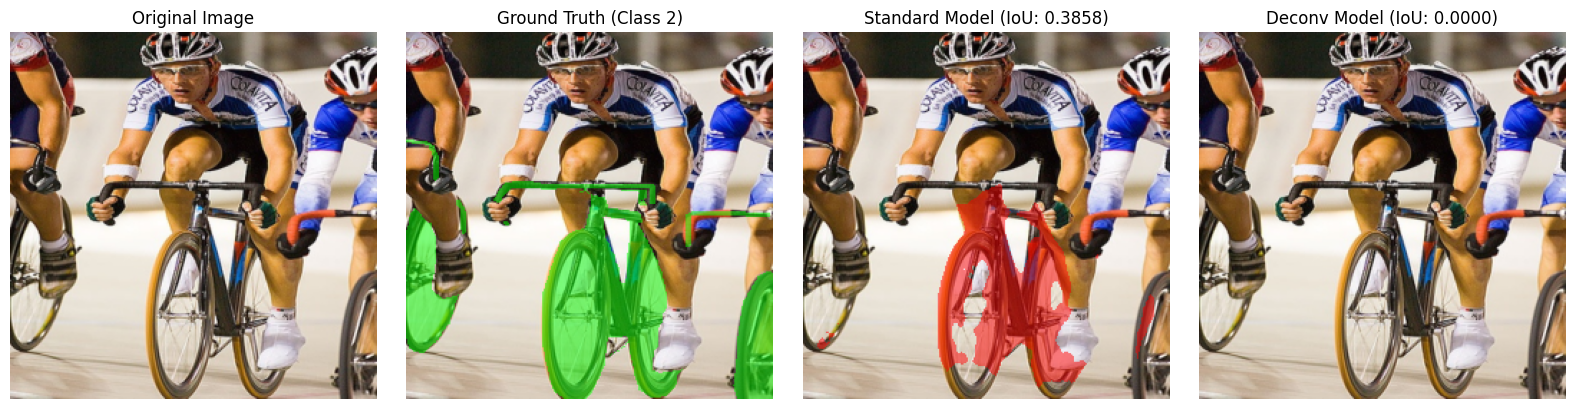

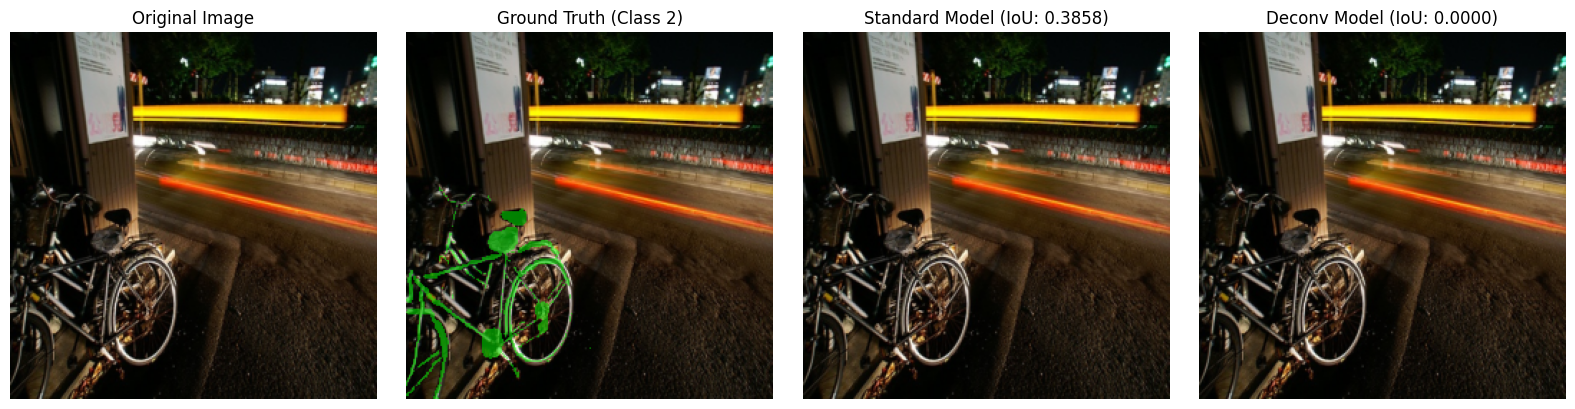

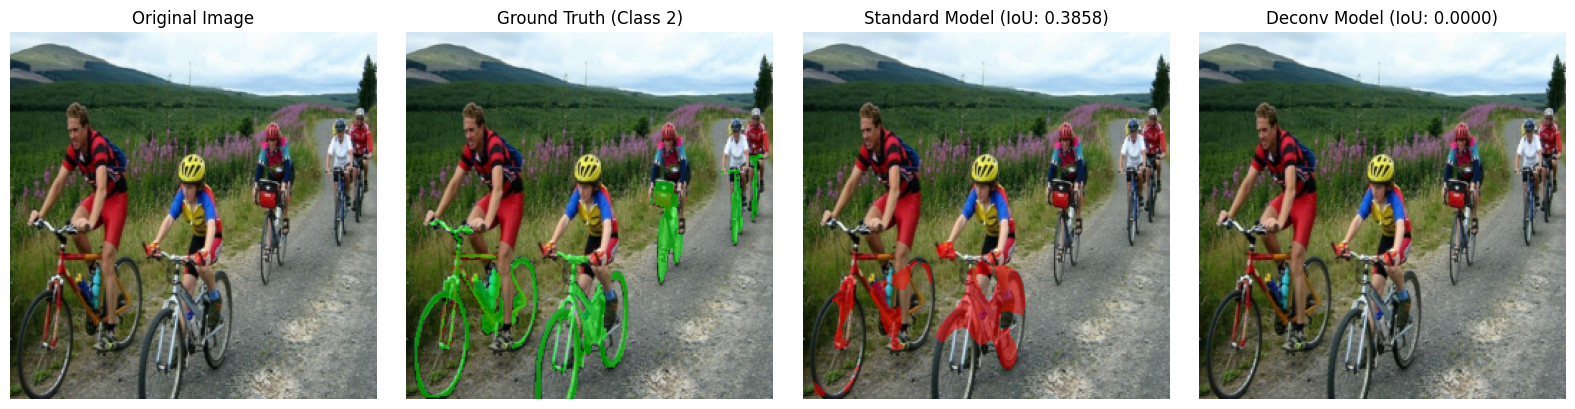


Class 0 examples (Deconv model outperforms Standard):


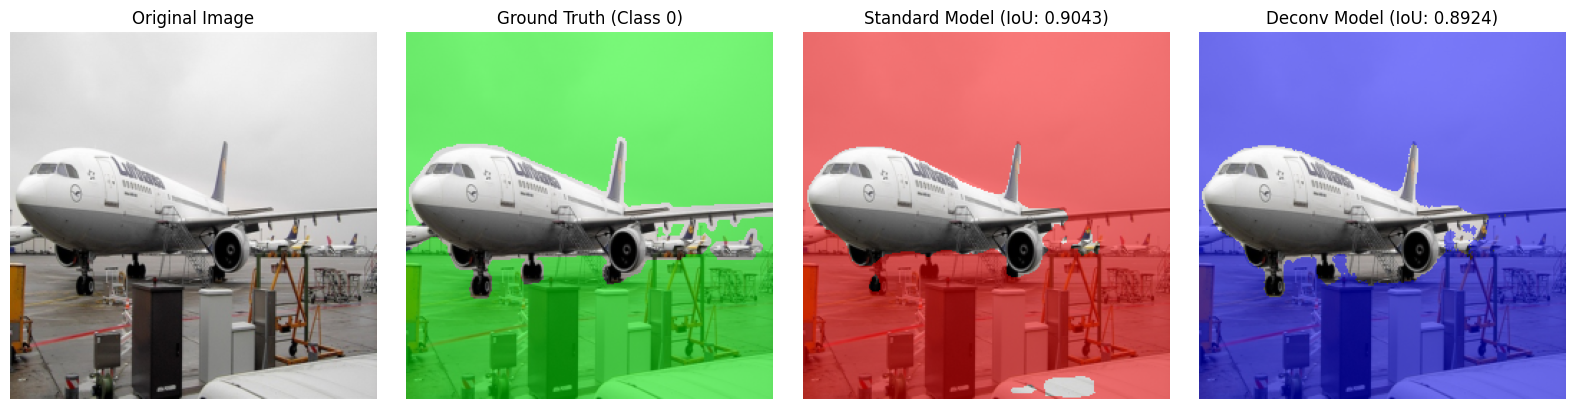

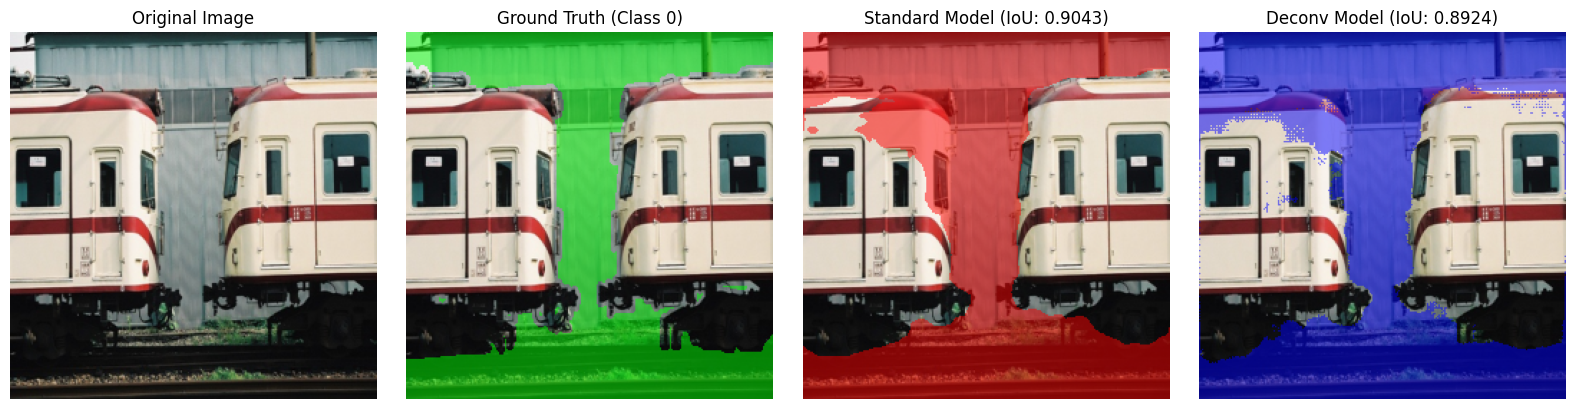

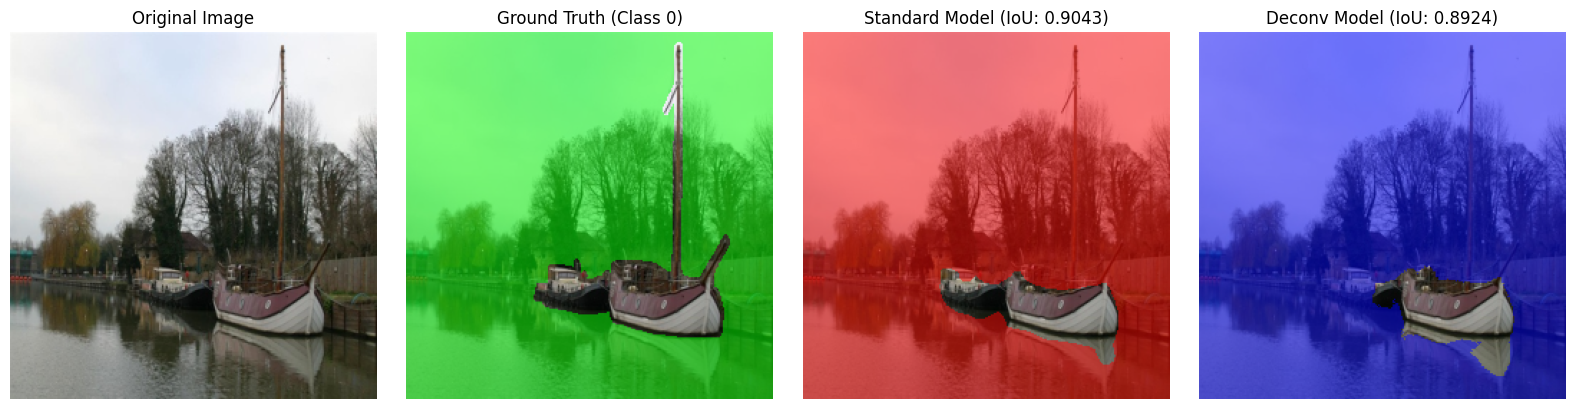

Standard model performs best on class 2 (bicycle)
Deconv model performs best on class: 0 (background)


In [ ]:
import os
import tqdm
import numpy as np
from tqdm.auto import tqdm
predictions_standard, predictions_deconv, ground_truth, images = get_predictions(
    model_standard, model_deconv, test_loader, device)

best_standard_class, best_deconv_class = find_best_classes_and_visualize(
    predictions_standard, predictions_deconv, ground_truth, images
)

# Print the results
print(f"Standard model performs best on class {best_standard_class} ({class_names[best_standard_class]})")
print(f"Deconv model performs best on class: {best_deconv_class} ({class_names[best_deconv_class]})")



Standard model performs worst on class 9 (IoU: 0.1537)
Deconv model performs worst on class 2 (IoU: 0.0000)

Class 9 examples (Standard model worst):


<ipython-input-5-23e7e4a14acc>:502: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)


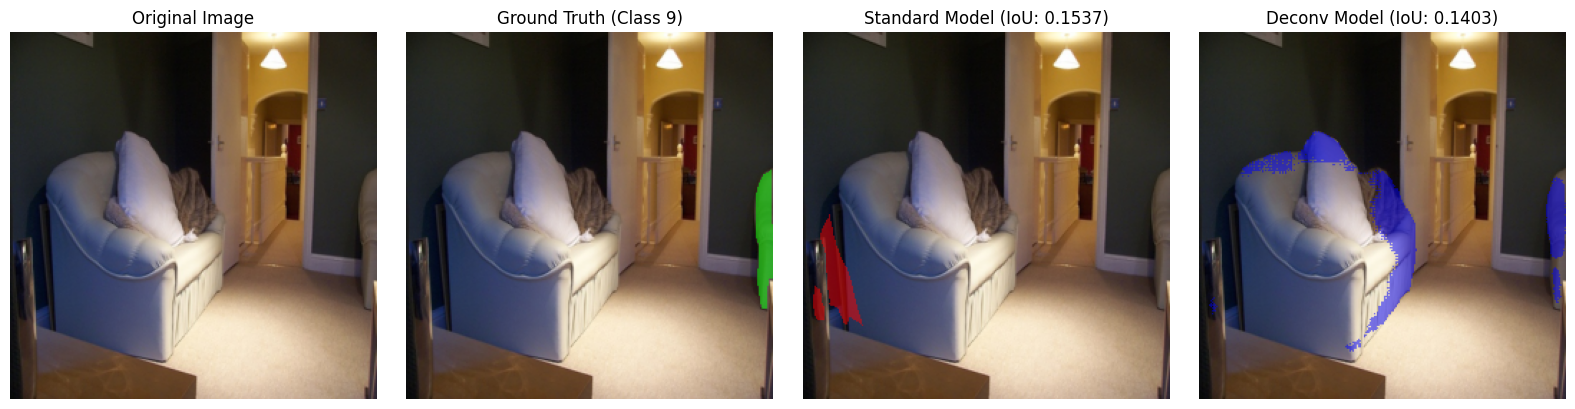

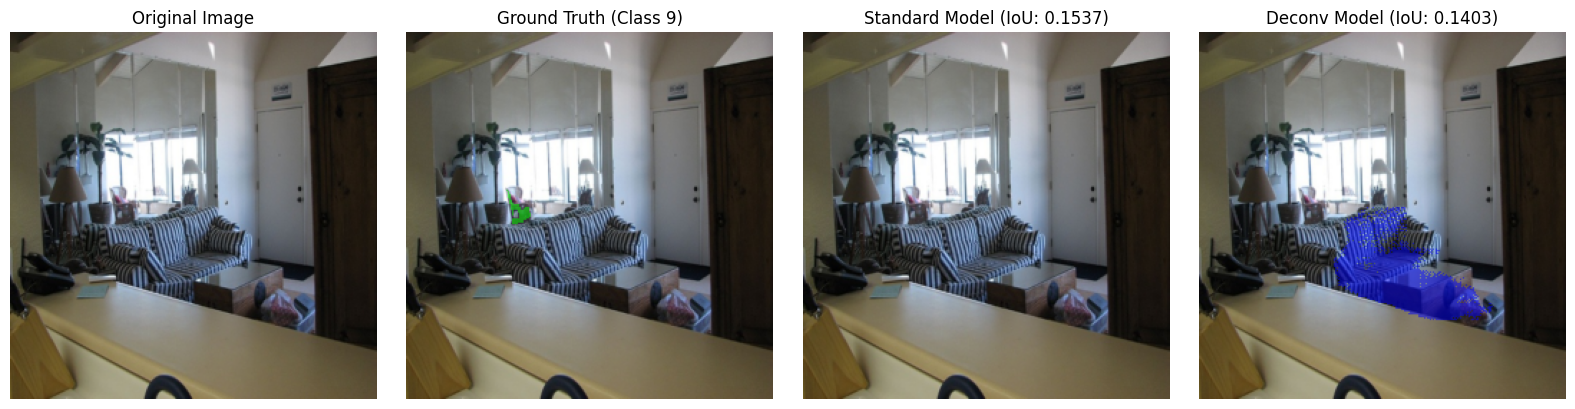

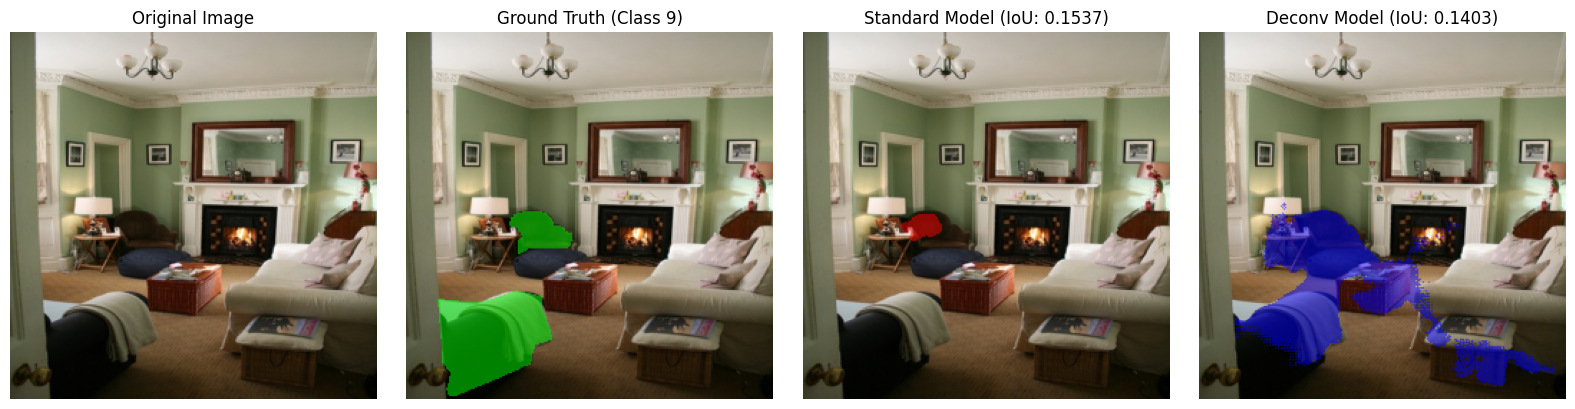


Class 2 examples (Deconv model worst):


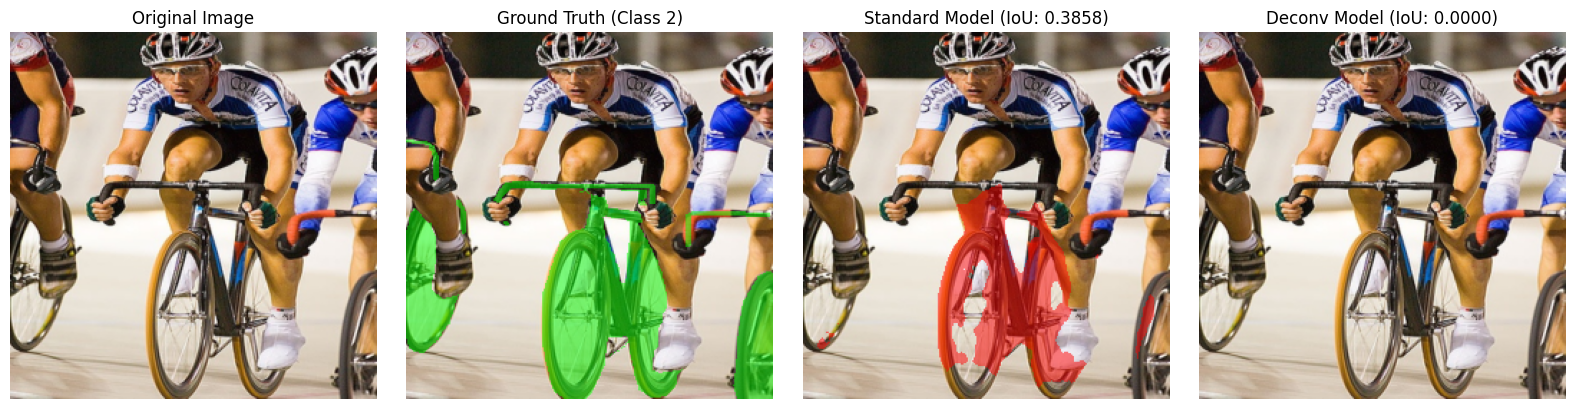

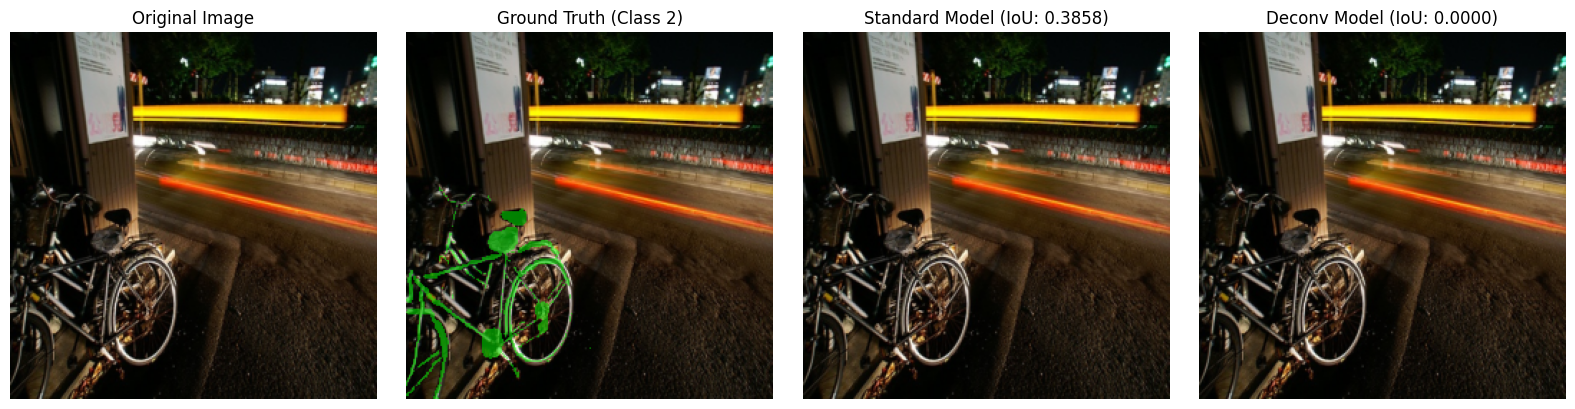

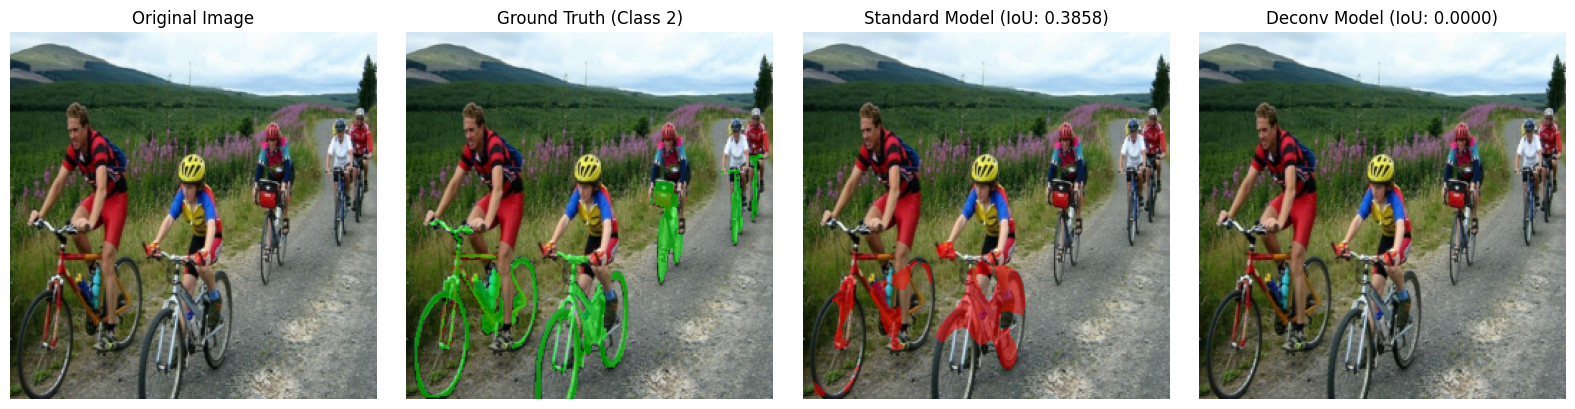

Standard model performs worst on class: 9 (chair)
Deconv model performs worst on class: 2 (bicycle)


In [ ]:
worst_standard_class, worst_deconv_class = find_worst_classes_and_visualize(
    predictions_standard, predictions_deconv, ground_truth, images
)
# Print the results
print(f"Standard model performs worst on class: {worst_standard_class} ({class_names[worst_standard_class]})")
print(f"Deconv model performs worst on class: {worst_deconv_class} ({class_names[worst_deconv_class]})")



Standard model most average on class 3 (IoU: 0.5452, mean: 0.5433)
Deconv model most average on class 12 (IoU: 0.4520, mean: 0.4431)

Class 3 examples (Standard model average):


<ipython-input-5-23e7e4a14acc>:652: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)


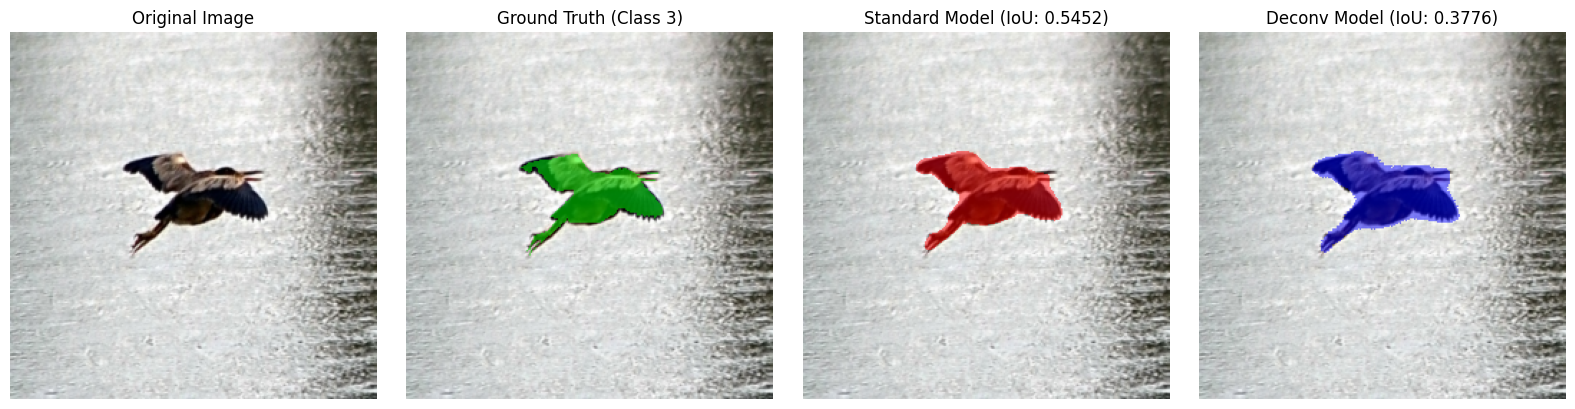

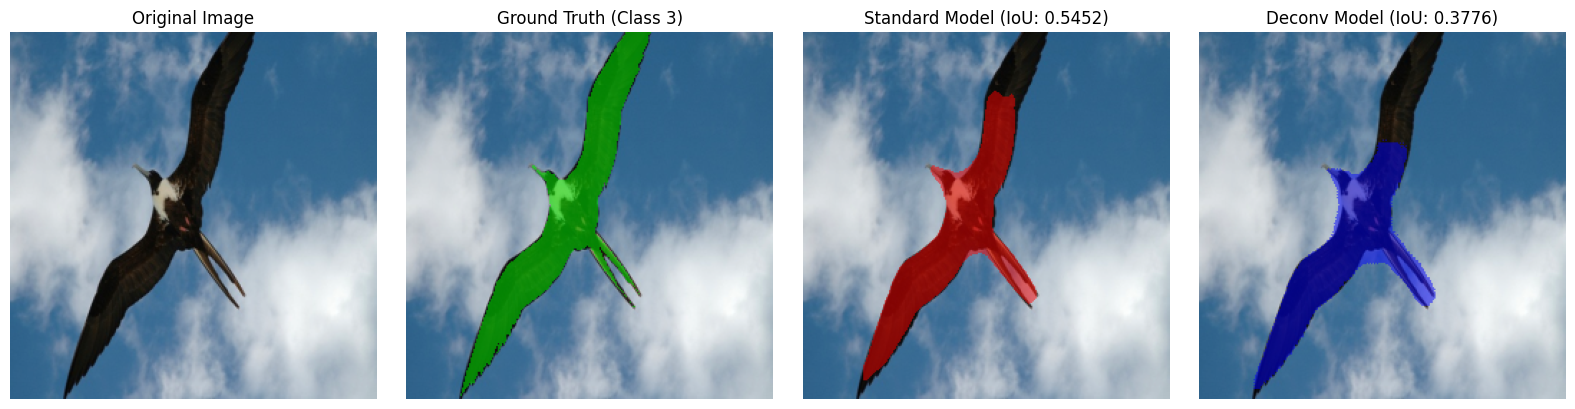

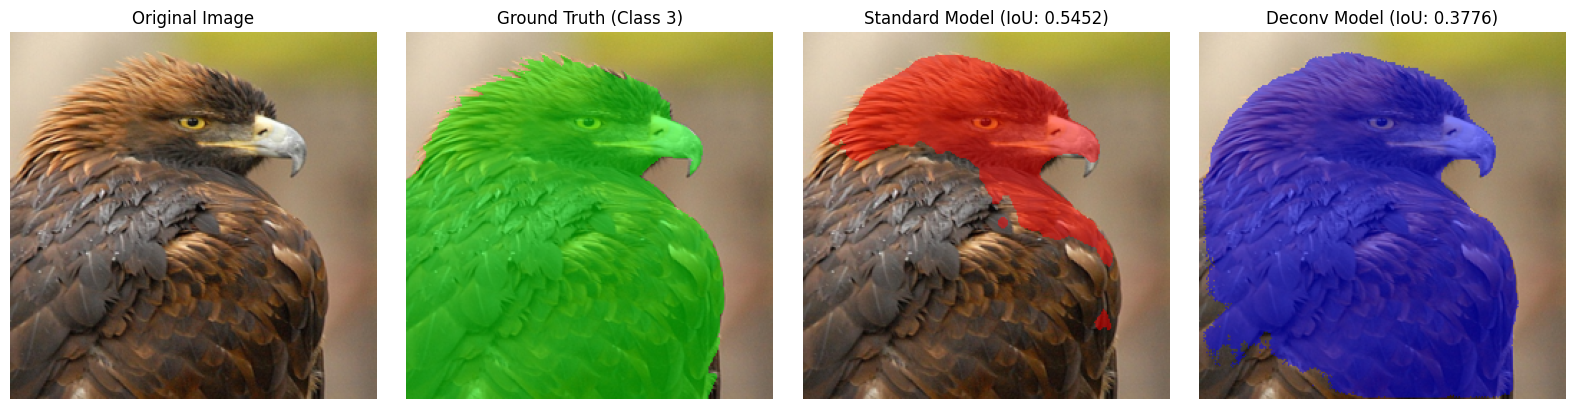


Class 12 examples (Deconv model average):


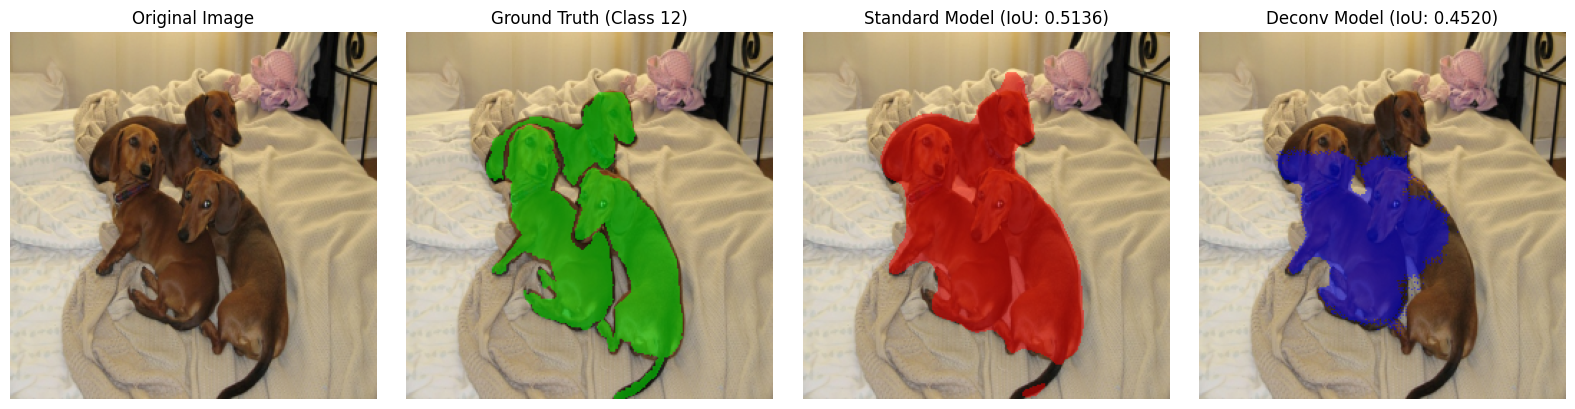

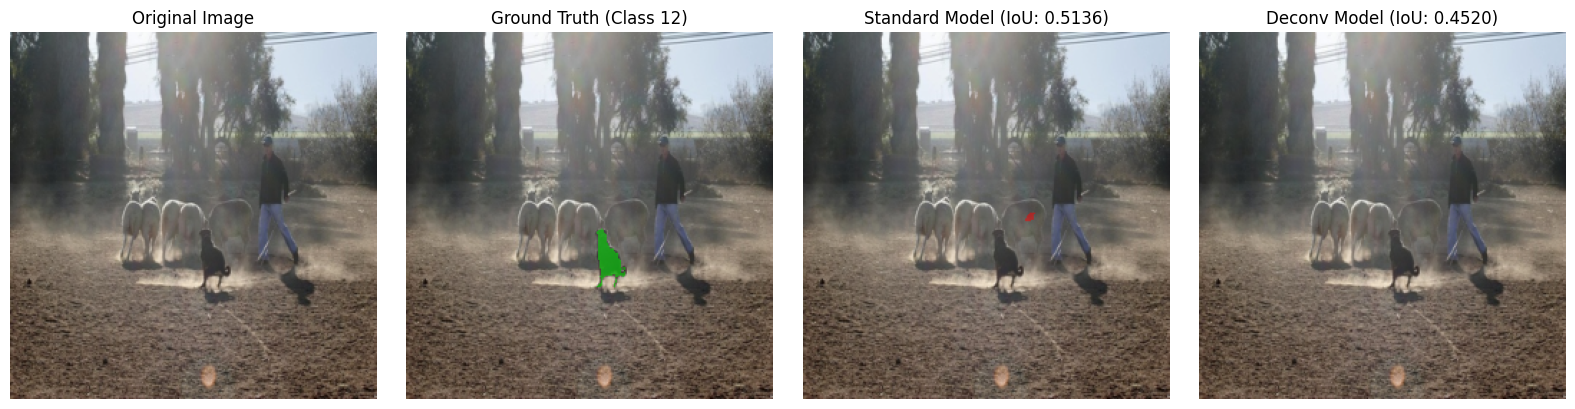

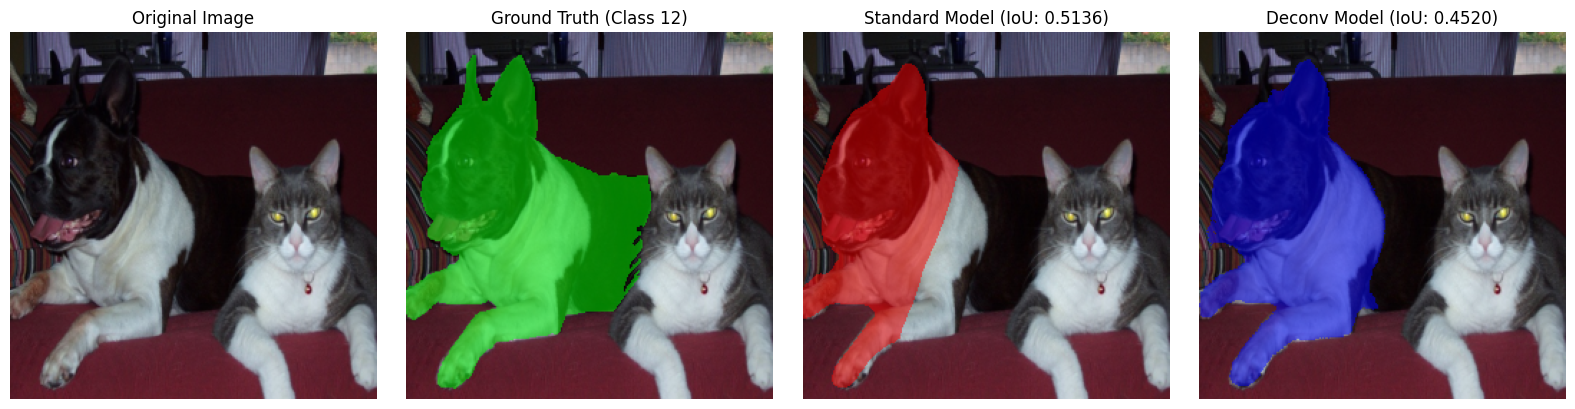

Standard model performs average on class: 3 (bird)
Deconv model performs average on class: 12 (dog)


In [ ]:
average_standard_class, average_deconv_class = find_average_classes_and_visualize(
    predictions_standard, predictions_deconv, ground_truth, images
)
#Print the results
print(f"Standard model performs average on class: {average_standard_class} ({class_names[average_standard_class]})")
print(f"Deconv model performs average on class: {average_deconv_class} ({class_names[average_deconv_class]})")